<a href="https://colab.research.google.com/github/raqgmar/tsa4dst/blob/main/02_02_SVR_20240511.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Preparación del entorno.

## 0.1 Definición de parámetros

In [22]:
tfm_path='/content/drive/MyDrive/TFM data/'
H1_code = 'OMNI2_H0_MRG1HR'
M5_code = 'OMNI_HRO2_5MIN'
lookback = 1
lookforward = 1
cols_to_use = ['Bx', 'By_gse', 'Bz_gse', 'By_gsm', 'Bz_gsm', 'P_density', 'E_field', 'plasma_T', 'plasma_V', 'Dst'] # 'AP', out
col_to_predict = "Dst"
hstorms_data = 'historical_storms_gruet2018.csv'
weak_threshold = -30 #1
moderate_threshold = -50 #2
strong_threshold = -100 #3
severe_threshold = -200 #4
great_threshold = -300 #5
temporal_margin=5*24 # margen para obtener tiempos ampliados de las tormentas d gruet et al 2018
test_size = 0.2

---

## 0.2 Montar Google Drive (obtención de datos)

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!rm -rf sample_data/

Mounted at /content/drive


## 0.3 Importación de librerías

In [4]:
# librerías de manipulación de datos y gráficos
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np

# modelo
from sklearn.svm import SVR

# escalado y división en train/test
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# obtención de métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_log_error, median_absolute_error
from sklearn.metrics import explained_variance_score, max_error

# meta
# timer
import time

## 0.4 Definición de funciones

In [5]:
def exploracion_inicial_datos(df):
    """
    Función para realizar una exploración inicial de los datos.

    Parámetros:
    df (dataframe): El dataframe que contiene los datos.

    Muestra las primeras filas, estadísticas descriptivas, valores faltantes,
    histogramas de variables numéricas y un mapa de calor de la correlación.
    """
    # Configuración de visualización
    sns.set(style="whitegrid")  # Estilo de gráficos


    print("Primeras filas del DataFrame:")
    print(df.head())


    print("\nDescripción estadística de los datos:")
    print(df.describe())


    print("\nValores faltantes por columna:")
    print(df.isnull().sum())


    print("\nVisualización de histogramas para variables numéricas:")
    df.hist(bins=15, figsize=(15, 10), layout=(5, 4))
    plt.show()
    print("\nMapa de calor de la matriz de correlación:")
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.show()


def calcular_layout_optimo(num_cols):
    """
    Calcula el número óptimo de filas y columnas para una figura con subgráficos,
    tratando de mantener una forma que sea visualmente agradable y que aproveche el espacio.

    Parámetros:
    num_cols (int): Número total de columnas (gráficos) a mostrar.

    Retorna:
    (int, int): Número de filas y columnas para el layout de los subgráficos.
    """
    # Calcula el número óptimo de columnas teniendo un límite visual razonable
    cols_per_row = int(np.sqrt(num_cols)) + 1  # Ajuste para maximizar el uso del espacio y la forma de la figura
    rows_needed = (num_cols + cols_per_row - 1) // cols_per_row  # Redondeo hacia arriba para incluir todas las columnas
    return rows_needed, cols_per_row

def exploracion_histogramas(df):
    """
    Función para generar histogramas para todas las columnas numéricas en un DataFrame,
    excluyendo las columnas de tipo datetime y no numéricas.

    Parámetros:
    df (DataFrame): DataFrame de pandas con los datos a analizar.
    """
    # Eliminar columnas no numéricas y de tipo datetime
    df_numerico = df.select_dtypes(include=[np.number])

    # Número de columnas numéricas
    num_cols = df_numerico.shape[1]

    # Verificar si hay columnas para mostrar
    if num_cols == 0:
        print("No hay columnas numéricas para mostrar.")
        return

    # Calculando el layout necesario
    rows_needed, cols_per_row = calcular_layout_optimo(num_cols)

    # Crear histogramas
    df_numerico.hist(bins=15, figsize=(15, 10), layout=(rows_needed, cols_per_row))
    plt.show()

def imputar_nan(df):
  df.interpolate(method='linear', inplace=True)
  df.fillna(method='ffill', inplace=True)
  df.fillna(method='bfill', inplace=True)
  if sum(df.isnull().sum())!=0:
    print("Faltan nulos por tratar")
  return df

def visualizar_nulos_plot(df, variable_with_nans):
    """
    Plot the specified 'variable_with_nans' column and 'Dst' column from the DataFrame.

    Parameters:
    - df: pandas.DataFrame containing the data to plot.
    - variable_with_nans: str, the name of the column in the DataFrame to plot, which may contain NaNs.

    The function assumes that 'Dst' is a column name in the DataFrame and that the DataFrame's index is suitable for plotting (e.g., datetime).
    """
    # Create the figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 8))

    # Handling NaNs in the 'variable_with_nans' column before plotting
    df_plot = df.copy()
    df_plot[variable_with_nans] = df_plot[variable_with_nans].fillna(method='ffill')  # Forward fill to handle NaNs

    # Plotting 'variable_with_nans' on the first subplot
    ax1.scatter(df_plot.index, df_plot[variable_with_nans], label=variable_with_nans, color='blue')
    ax1.set_ylabel(variable_with_nans)
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # Plotting 'Dst' on the second subplot
    ax2.plot(df_plot.index, df_plot['Dst'], label='Dst', color='red')
    ax2.set_ylabel('Dst')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    # Setting the x-axis label only on the bottom subplot
    ax2.set_xlabel('Datetime')

    # Improve layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example of how to use this function with a DataFrame containing NaNs
data = {
    'Datetime': pd.date_range(start='2021-01-01', periods=100, freq='D'),
    'variable_with_nans': pd.Series(range(100)).where(lambda x : x % 10 != 0),
    'Dst': range(100, 0, -1)
}
df = pd.DataFrame(data)
df.set_index('Datetime', inplace=True)



def filter_storms(df, historical_storms, temporal_margin):
    """
    Filter DataFrame entries based on the occurrence of storms within specific time intervals.

    Parameters:
    df (pandas.DataFrame): DataFrame containing time-series data with a 'Datetime' column.
    historical_storms (pandas.DataFrame): DataFrame containing the start and end times of historical storms.
    temporal_margin (int): Number of rows before and after the minimum Dst index to include in the result.

    Returns:
    list: A list of DataFrame snippets corresponding to the specified storm intervals.
    """
    all_storms = []
    for i in range(len(historical_storms)):
        df_tmp = df[(df["Datetime"] >= historical_storms.iloc[i]["start"]) & (df["Datetime"] <= historical_storms.iloc[i]["end"])]
        idx = df_tmp['Dst'].idxmin()
        all_storms.append(df.iloc[idx-temporal_margin:idx+temporal_margin])
    return all_storms

def combinar_dataframes_solapados(dfs):
    """
    Combines overlapping DataFrames in a list into non-overlapping DataFrames based on the 'Datetime' column.

    Parameters:
    dfs (list of pandas.DataFrame): List of DataFrames to combine.

    Returns:
    list: A list of combined DataFrames without overlap.
    """
    dfs.sort(key=lambda x: x['Datetime'].min())
    combinados = []
    combinacion_actual = dfs[0]

    for df in dfs[1:]:
        if df['Datetime'].min() <= combinacion_actual['Datetime'].max():
            combinacion_actual = pd.concat([combinacion_actual, df]).drop_duplicates().sort_values(by='Datetime')
        else:
            combinados.append(combinacion_actual)
            combinacion_actual = df
    combinados.append(combinacion_actual)
    return combinados

def scale_data(list_dfs, cols_to_use, col_to_predict):
    """
    Scales columns in a list of DataFrames using StandardScaler.

    Parameters:
    list_dfs (list of pandas.DataFrame): List of DataFrames to scale.
    cols_to_use (list of str): Column names to apply scaling to.
    col_to_predict (str): Column name used as a label for prediction.

    Returns:
    tuple: A tuple containing the list of scaled DataFrames and the label scaler.
    """
    list_dfs_ = []
    scaler_cols = StandardScaler()
    scaler_label = StandardScaler()
    scaler_cols.fit(pd.concat(list_dfs)[cols_to_use])
    scaler_label.fit(np.asarray(pd.concat(list_dfs)[col_to_predict]).reshape(-1,1))

    for df_ in list_dfs:
        df = df_.copy()
        df[cols_to_use] = scaler_cols.transform(df[cols_to_use])
        list_dfs_.append(df)

    return list_dfs_, scaler_label

def create_window_df_svr(list_dfs, lookback, lookforward, cols_to_use, col_to_predict, scaler_label=None):
    """
    Creates input and output datasets for SVR training from a list of DataFrames, incorporating windowing and optional descaling for target

    Parameters:
    list_dfs (list of pandas.DataFrame): List of DataFrames to process.
    lookback (int): Number of past records to include as features for each prediction.
    lookforward (int): Number of records ahead to predict.
    cols_to_use (list of str): List of column names to use as features.
    col_to_predict (str): Column name to predict.
    scaler_label (StandardScaler, optional): Scaler for the output variable, used for inverse transformation.

    Returns:
    tuple: A tuple containing arrays for training features and labels.
    """
    x_train, y_train = [], []

    for df_ in list_dfs:
        df = df_.copy()

        for i in range(len(df) - lookback - lookforward + 1):
            x_train.append(np.asarray(df.iloc[i:i+lookback][cols_to_use].values))
            y_train.append(np.asarray(df.iloc[i+lookback][col_to_predict]))

    if scaler_label is not None:
        y_train = scaler_label.inverse_transform(np.asarray(y_train).reshape(-1,1))

    return np.asarray(x_train), np.asarray(y_train)

def calc_metrics(predictions, y_test):
  # Mean Squared Error
  mse = mean_squared_error(y_test, predictions)
  # Mean Absolute Error
  mae = mean_absolute_error(y_test, predictions)
  # R^2 Score, the coefficient of determination
  r2 = r2_score(y_test, predictions)
  # Mean Squared Logarithmic Error
  msle = mean_squared_log_error(y_test, predictions)
  # Median Absolute Error
  medae = median_absolute_error(y_test, predictions)
  # Explained Variance Score
  explained_variance = explained_variance_score(y_test, predictions)
  # Max Error
  max_err = max_error(y_test, predictions)

  return mse, mae, r2, msle, medae, explained_variance, max_err


def formatear_tiempo(segundos):
    horas = int(segundos // 3600)
    minutos = int((segundos % 3600) // 60)
    segundos = segundos % 60
    return f"{horas} horas, {minutos} minutos, {segundos:.2f} segundos"

def evaluate_svr_models(X_train, y_train, X_test, y_test, kernels, C=1.0, epsilon=0.1, gamma='auto', degree=3):
    # Initialize lists to store the results
    mse_list = []
    mae_list = []
    r2_list = []
    msle_list = []
    medae_list = []
    exp_var_list = []
    max_err_list = []
    time_list = []

    # Loop through each kernel type
    for kernel_ in kernels:
        start = time.time()
        print("Starting {}".format(kernel_))

        # Select the kernel type
        if kernel_ == "precomputed":
            # Assume precomputed_matrix is already defined and available
            model = SVR(kernel='precomputed', C=C, epsilon=epsilon)
            if 'precomputed_matrix' in locals():
                model.fit(precomputed_matrix, y_train)
                continue  # Skip the rest of the loop if using precomputed kernel
            else:
                print("Precomputed matrix not defined for kernel='precomputed'")
                continue
        else:
            model = SVR(kernel=kernel_, C=C, epsilon=epsilon, gamma=gamma, degree=(degree if kernel_ == 'poly' else 3))

        # Fit the model on training data
        model.fit(X_train, y_train)

        # Prediction and Evaluation
        predictions = model.predict(X_test)
        mse, mae, r2, msle, medae, explained_variance, max_err = calc_metrics(predictions, y_test)

        # Append results to lists
        mse_list.append(mse)
        mae_list.append(mae)
        r2_list.append(r2)
        msle_list.append(msle)
        medae_list.append(medae)
        exp_var_list.append(explained_variance)
        max_err_list.append(max_err)

        end = time.time()
        time_exec = formatear_tiempo(end-start)
        time_list.append(time_exec)
        print("{} finished. Time for iteration: {}".format(kernel_, time_exec))

    # Compile results into a DataFrame
    df_results = pd.DataFrame({
        "kernel": kernels,
        "mse": mse_list,
        "mae": mae_list,
        "r2": r2_list,
        "msle": msle_list,
        "medae": medae_list,
        "exp_var": exp_var_list,
        "max_err": max_err_list,
        "time_exec": time_list
    })

    return df_results


# 1. Carga y preparación de datos

## 1.1 Carga de los datos

In [6]:
hd = pd.read_csv(tfm_path+H1_code+'.csv', parse_dates=["Datetime"])
# md = pd.read_csv(tfm_path+M5_code+'.csv', parse_dates=["Datetime"]) # no se va a usar por ahora
historical_storms = pd.read_csv(tfm_path+hstorms_data)
# historical_storms = historical_storms.drop(columns=['Min. Dst (nT)','Unnamed: 0'], axis=1)

- Ver qué columnas y tipo de datos contienen los df.

In [7]:
hd.columns

Index(['ID_IMF', 'ID_plasma', 'Bmag', 'dev_Bmag', 'Bx', 'By_gse', 'Bz_gse',
       'By_gsm', 'Bz_gsm', 'dev_Bx', 'dev_By', 'dev_Bz', 'P_density',
       'dev_P_density', 'AP', 'dev_AP', 'E_field', 'plasma_T', 'dev_plasma_T',
       'plasma_V', 'Dst', 'Datetime'],
      dtype='object')

In [8]:
hd.dtypes

ID_IMF                  float64
ID_plasma               float64
Bmag                    float64
dev_Bmag                float64
Bx                      float64
By_gse                  float64
Bz_gse                  float64
By_gsm                  float64
Bz_gsm                  float64
dev_Bx                  float64
dev_By                  float64
dev_Bz                  float64
P_density               float64
dev_P_density           float64
AP                      float64
dev_AP                  float64
E_field                 float64
plasma_T                float64
dev_plasma_T            float64
plasma_V                float64
Dst                     float64
Datetime         datetime64[ns]
dtype: object

In [9]:
historical_storms.columns

Index(['Unnamed: 0', 'Min. Dst (nT)', 'start', 'end', 'storm'], dtype='object')

In [10]:
historical_storms.dtypes

Unnamed: 0        int64
Min. Dst (nT)     int64
start            object
end              object
storm             int64
dtype: object

- Ordenar las tormentas en caso de que no lo estén
- Convertir todas las fechas a datetime de pd.

In [11]:
# Ordenar los dataframes por fecha
historical_storms = historical_storms.sort_values(by='start')

# convertir las columnas de tiempo a datetime64
hd['Datetime']=pd.to_datetime(hd['Datetime'])
historical_storms['start']=pd.to_datetime(historical_storms['start'])
historical_storms['end']=pd.to_datetime(historical_storms['end'])

# Cuando se utilizan los datos a 5 minutos, se unen a 5min
#data = pd.merge(md, hd[["Datetime", "Dst"]], on='Datetime', how='left')

## 1.2 Exploración inicial de los datos

- head del df

In [12]:
hd.head()

,ID_IMF,ID_plasma,Bmag,dev_Bmag,Bx,By_gse,Bz_gse,By_gsm,Bz_gsm,dev_Bx,...,P_density,dev_P_density,AP,dev_AP,E_field,plasma_T,dev_plasma_T,plasma_V,Dst,Datetime
0,71.0,71.0,4.6,0.4,-3.8,1.7,-1.2,2.0,-0.7,0.5,...,NaN,NaN,0.015,0.001,0.20,NaN,NaN,290.0,-6.0,2001-01-01 00:00:00
1,71.0,71.0,3.5,0.1,-3.1,0.7,-1.4,1.0,-1.2,0.1,...,NaN,NaN,0.015,0.002,0.35,NaN,NaN,292.0,-2.0,2001-01-01 01:00:00
2,71.0,71.0,3.9,0.3,-3.4,0.5,-1.8,0.9,-1.7,0.2,...,NaN,NaN,0.012,0.001,0.49,NaN,NaN,287.0,2.0,2001-01-01 02:00:00
3,71.0,71.0,3.6,0.3,-3.0,0.7,-1.8,1.0,-1.7,0.2,...,NaN,NaN,0.012,0.002,0.49,NaN,NaN,286.0,4.0,2001-01-01 03:00:00
4,71.0,71.0,3.1,0.2,-2.4,1.2,-1.4,1.3,-1.3,0.3,...,NaN,NaN,0.012,0.001,0.37,NaN,NaN,286.0,1.0,2001-01-01 04:00:00


- descripción estadística de los datos

In [13]:
hd.describe()

,ID_IMF,ID_plasma,Bmag,dev_Bmag,Bx,By_gse,Bz_gse,By_gsm,Bz_gsm,dev_Bx,...,P_density,dev_P_density,AP,dev_AP,E_field,plasma_T,dev_plasma_T,plasma_V,Dst,Datetime
count,122712.000000,122586.000000,122712.000000,122712.00000,122712.000000,122712.000000,122712.000000,122712.000000,122712.000000,122712.000000,...,119308.000000,119308.000000,108014.000000,108014.000000,122586.000000,1.197670e+05,1.197670e+05,122586.000000,122712.000000,122712
mean,55.121357,55.882450,5.671726,0.35294,0.047857,-0.052421,-0.003823,-0.051103,0.021510,1.006653,...,5.653157,0.624578,0.034996,0.005249,-0.009856,9.666483e+04,1.489926e+04,431.722970,-12.386710,2008-01-01 11:30:00
min,51.000000,50.000000,0.400000,0.00000,-40.800000,-33.000000,-53.700000,-43.100000,-57.800000,0.000000,...,0.100000,0.000000,0.001000,0.000000,-35.940000,3.299000e+03,0.000000e+00,233.000000,-422.000000,2001-01-01 00:00:00
25%,51.000000,52.000000,3.700000,0.10000,-2.400000,-2.500000,-1.300000,-2.400000,-1.400000,0.500000,...,2.800000,0.200000,0.020000,0.002000,-0.610000,3.609750e+04,4.451000e+03,352.000000,-20.000000,2004-07-02 05:45:00
50%,51.000000,52.000000,5.000000,0.20000,0.100000,-0.100000,0.000000,-0.100000,0.000000,0.800000,...,4.400000,0.400000,0.033000,0.004000,0.000000,6.873900e+04,9.376000e+03,407.000000,-9.000000,2008-01-01 11:30:00
75%,51.000000,52.000000,6.800000,0.40000,2.400000,2.400000,1.300000,2.300000,1.500000,1.300000,...,6.900000,0.700000,0.047000,0.006000,0.590000,1.268440e+05,1.785400e+04,490.000000,-1.000000,2011-07-02 17:15:00
max,71.000000,71.000000,62.000000,23.30000,26.400000,46.100000,37.500000,39.600000,41.600000,23.800000,...,112.300000,62.500000,0.583000,0.421000,33.870000,6.632456e+06,3.532095e+06,1189.000000,77.000000,2014-12-31 23:00:00
std,8.089629,7.706407,3.142017,0.44518,3.388127,3.836403,2.837885,3.736054,2.968824,0.810626,...,4.655746,0.971330,0.021252,0.005911,1.394311,9.970365e+04,3.023036e+04,106.768314,20.348476,NaN


- ver los valores nulos

In [14]:
hd.isnull().sum()

ID_IMF               0
ID_plasma          126
Bmag                 0
dev_Bmag             0
Bx                   0
By_gse               0
Bz_gse               0
By_gsm               0
Bz_gsm               0
dev_Bx               0
dev_By               0
dev_Bz               0
P_density         3404
dev_P_density     3404
AP               14698
dev_AP           14698
E_field            126
plasma_T          2945
dev_plasma_T      2945
plasma_V           126
Dst                  0
Datetime             0
dtype: int64

In [15]:
hd.isnull().sum() / len(hd) * 100

ID_IMF            0.000000
ID_plasma         0.102679
Bmag              0.000000
dev_Bmag          0.000000
Bx                0.000000
By_gse            0.000000
Bz_gse            0.000000
By_gsm            0.000000
Bz_gsm            0.000000
dev_Bx            0.000000
dev_By            0.000000
dev_Bz            0.000000
P_density         2.773975
dev_P_density     2.773975
AP               11.977639
dev_AP           11.977639
E_field           0.102679
plasma_T          2.399928
dev_plasma_T      2.399928
plasma_V          0.102679
Dst               0.000000
Datetime          0.000000
dtype: float64

- Histograma para variables numéricas (todas, en este caso, pero hemos quitado datetime porque no es muy util al ser una serie temporal).

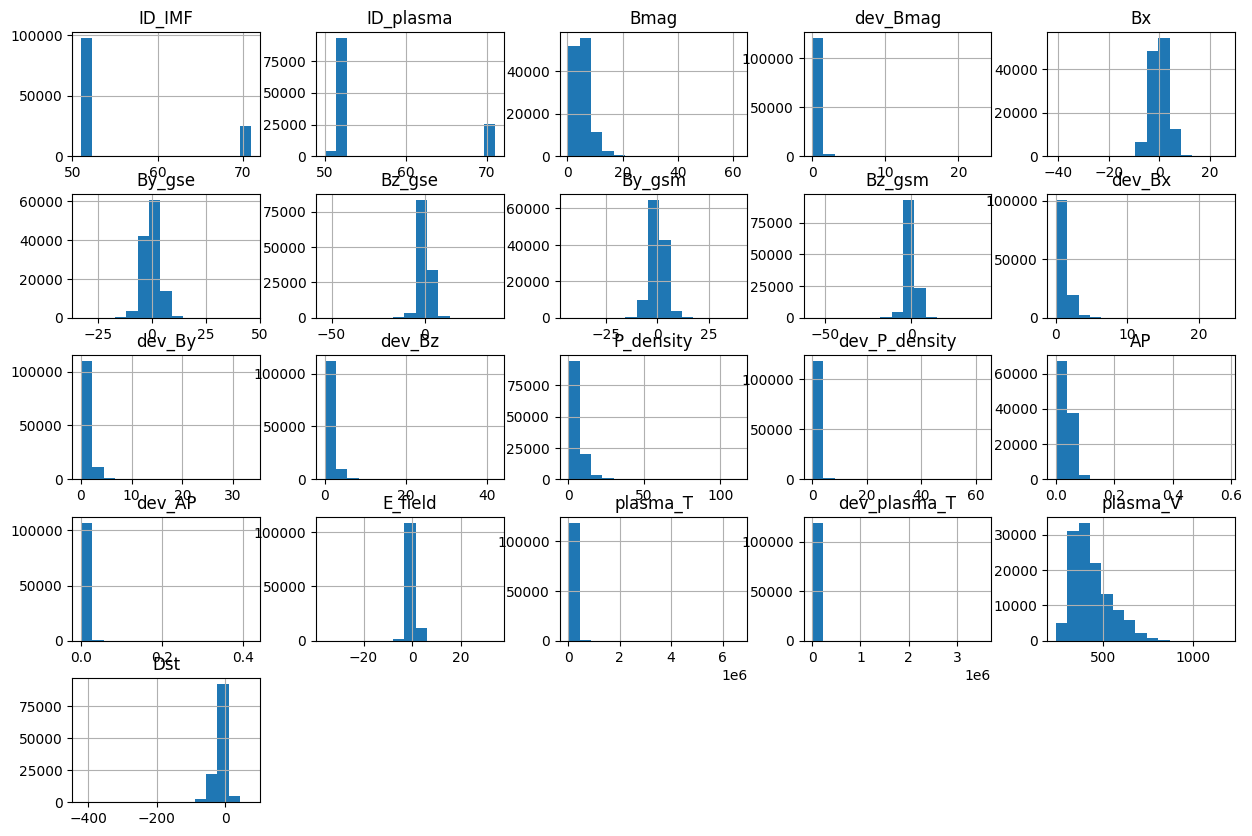

In [16]:
exploracion_histogramas(hd)

- Visualizaciónd e historical_storms

In [17]:
storms_data = historical_storms.copy()

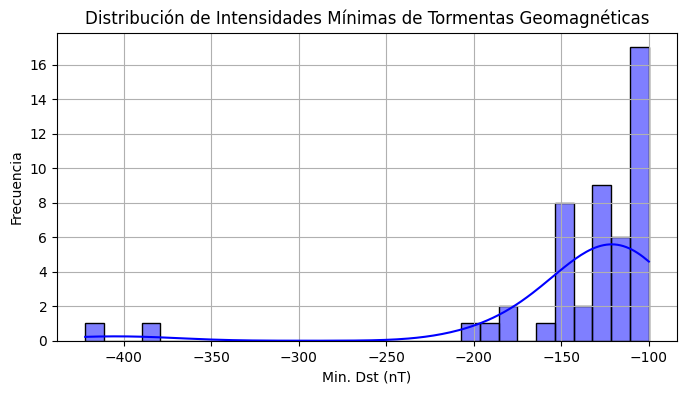

In [18]:
# Convertir las columnas de fecha y hora a datetime
storms_data['start'] = pd.to_datetime(storms_data['start'])
storms_data['end'] = pd.to_datetime(storms_data['end'])
# Calcular la duración de cada tormenta en horas
storms_data['duration_hours'] = (storms_data['end'] - storms_data['start']).dt.total_seconds() / 3600

# Gráfico de la distribución de las intensidades mínimas de las tormentas
plt.figure(figsize=(8, 4))
sns.histplot(storms_data['Min. Dst (nT)'], bins=30, kde=True, color='blue')
plt.title('Distribución de Intensidades Mínimas de Tormentas Geomagnéticas')
plt.xlabel('Min. Dst (nT)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Gráfico de dispersión entre la duración y la intensidad mínima

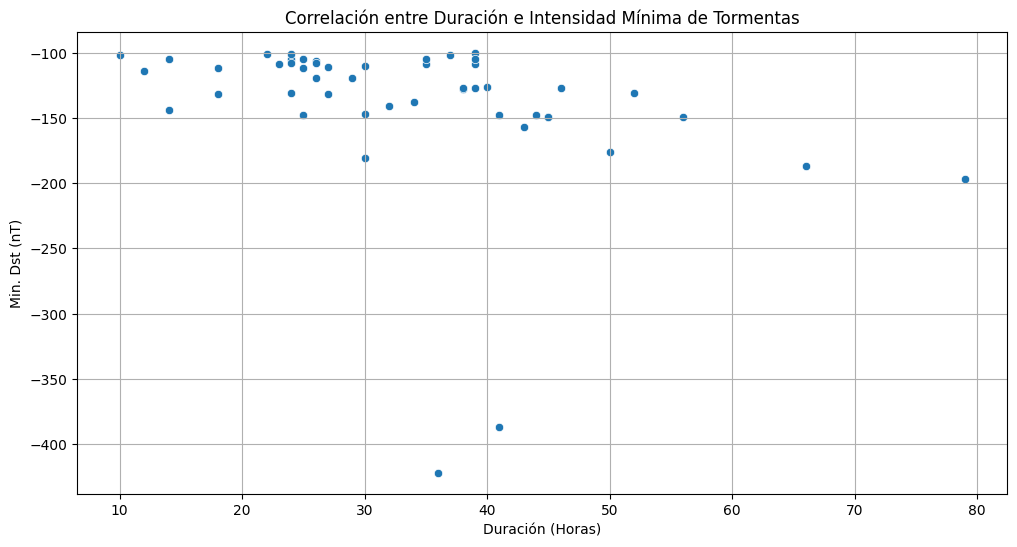

In [19]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='duration_hours', y='Min. Dst (nT)', data=storms_data)
plt.title('Correlación entre Duración e Intensidad Mínima de Tormentas')
plt.xlabel('Duración (Horas)')
plt.ylabel('Min. Dst (nT)')
plt.grid(True)
plt.show()

- Ver el timeline de las tormentas

In [20]:
# import plotly.graph_objects as go

# # Crear la figura
# fig = go.Figure()

# # Añadir cada tormenta como un segmento de línea en el gráfico
# for i, row in storms_data.iterrows():
#     fig.add_trace(go.Scatter(
#         x=[row['start'], row['end']],
#         y=[i, i],
#         mode='lines+markers',
#         name=f"Tormenta {row['storm']}"
#     ))

# # Ajustar la presentación de la figura
# fig.update_layout(
#     title="Línea de Tiempo de Tormentas Históricas",
#     xaxis_title="Fecha",
#     yaxis_title="Tormenta",
#     yaxis=dict(
#         tickmode='array',
#         tickvals=list(range(len(storms_data)))
#     ),
#     showlegend=False,
#     xaxis=dict(
#         rangeslider=dict(
#             visible=True
#         ),
#         type="date"
#     )
# )

# # Mostrar la figura
# fig.show()

Mapa de calor de la matriz de correlación

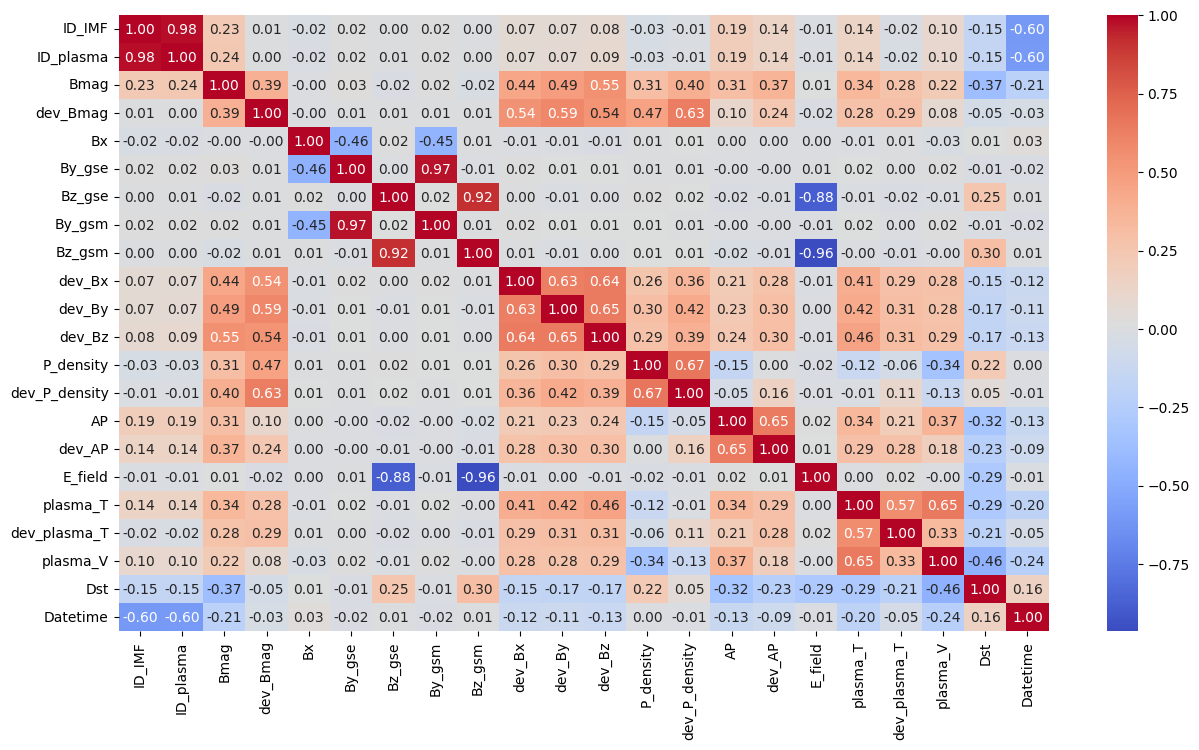

In [21]:
plt.figure(figsize=(15, 8))
sns.heatmap(hd.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

## 1.3 Limpieza y procesamiento de los datos

### 1.3.1 Tratamiento de valores faltantes

In [23]:
sum(hd.isnan().sum())

AttributeError: 'DataFrame' object has no attribute 'isnan'

### 1.3.2 Normalización de los datos

In [ ]:
all_storms = filter_storms(hd, historical_storms, temporal_margin)
all_storms = combinar_dataframes_solapados(all_storms)
all_storms, scaler_target = scale_data(all_storms, cols_to_use, col_to_predict)

### 1.3.3 Codificación de variables categóricas

* No existe codificación de variables categóricas porque **no hay variables categóricas). A continuación, se muestra.

In [ ]:
pd.concat(all_storms).dtypes

ID_IMF                  float64
ID_plasma               float64
Bmag                    float64
dev_Bmag                float64
Bx                      float64
By_gse                  float64
Bz_gse                  float64
By_gsm                  float64
Bz_gsm                  float64
dev_Bx                  float64
dev_By                  float64
dev_Bz                  float64
P_density               float64
dev_P_density           float64
AP                      float64
dev_AP                  float64
E_field                 float64
plasma_T                float64
dev_plasma_T            float64
plasma_V                float64
Dst                     float64
Datetime         datetime64[ns]
dtype: object

# 3 Entrenamiento de modelos

## 3.1 Creación de la ventana temporal

In [ ]:
x_window, y_window = create_window_df_svr(all_storms, scaler_target) # desescalado
# x_window, y_window = create_window_df_svr(all_storms) # sin desescalar

## 3.2 División en train-test.

In [ ]:
# Preprocessing
X = x_window[cols_to_use]
y = y_window[col_to_predict]

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

# 4 Evaluación de modelos

# 5 Visualización de resultados

## Linear